# Effect of Time-Window Rejection on Horizontal-to-Vertical Spectral Ratio (HVSR) Measurements from Microtremor Recordings (mHVSR)

## License Information

This file is part of _hvsrpy_, a Python package for horizontal-to-vertical spectral ratio processing.

    Copyright (C) 2019-2024 Joseph P. Vantassel (joseph.p.vantassel@gmail.com)

    This program is free software: you can redistribute it and/or modify
    it under the terms of the GNU General Public License as published by
    the Free Software Foundation, either version 3 of the License, or
    (at your option) any later version.

    This program is distributed in the hope that it will be useful,
    but WITHOUT ANY WARRANTY; without even the implied warranty of
    MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
    GNU General Public License for more details.

    You should have received a copy of the GNU General Public License
    along with this program.  If not, see <https: //www.gnu.org/licenses/>.
    
## About _hvsrpy_

_hvsrpy_ is an open-source Python package for performing horizontal-to-vertical spectral ratio (HVSR) processing of microtremor and earthquake recordings. _hvsrpy_ was developed by [Jospeh P. Vantassel](https://www.jpvantassel.com/) with contributions from Dana M. Brannon under the supervision of Professor Brady R. Cox at The University of Texas at Austin. _hvsrpy_ continues to be developed and maintained by [Joseph P. Vantassel and his research group at Virginia Tech](https://geoimaging-research.org/).

## Citation

If you use _hvsrpy_ in your research or consulting, we ask you please cite the following:

>Joseph Vantassel. (2020). jpvantassel/hvsrpy: latest (Concept). Zenodo.
[http://doi.org/10.5281/zenodo.3666956](http://doi.org/10.5281/zenodo.3666956)

_Note: For software, version specific citations should be preferred to
general concept citations, such as that listed above. To generate a version
specific citation for hvsrpy, please use the citation tool on the hvsrpy
[archive](http://doi.org/10.5281/zenodo.3666956)._

## About this notebook

This notebook demonstrates how the time-window rejection algorithms offered by _hvsrpy_ affect the HVSR results.
The automated frequency-domain window-rejection algorithm and lognormal statistics implemented in `hvsrpy` were developed by Cox et al. (2020).
If you use either of these feature, please also cite Cox et al. (2020) to recognize their original work.

> Cox, B. R., Cheng, T., Vantassel, J. P., & Manuel, L. (2020). "A statistical
> representation and frequency-domain window-rejection algorithm for single-station
> HVSR measurements. Geophysical Journal International, 221(3), 2170–2183.
> https://doi.org/10.1093/gji/ggaa119

The microtremor data presented are those by Cox and Vantassel (2018).
If you use this data, please also cite Cox and Vantassel (2018).

>Cox, B.R. and Vantassel, J.P. (2018). Dynamic Characterization of Wellington, New Zealand. DesignSafe-CI [publisher]. https://doi.org/10.17603/DS24M6J

## Getting Started

1. Install _hvsrpy_, with `pip install hvsrpy`. More information on _pip_ can be found [here](https://jpvantassel.github.io/python3-course/#/intro/pip). __(~3 minutes)__
2. Try analyzing the provided examples. __(~10 minutes)__
3. Try your own files by changing the file names below. __(~15 minutes)__

Happy Processing!

In [1]:
import time
import pathlib

import numpy as np
import matplotlib.pyplot as plt

import hvsrpy

plt.style.use("./data/hvsrpy.mplstyle")

## Input Data

In [2]:
# Input file name (may be a relative or full path).
# fnames = [["./data/UT.STN11.A2_C50.miniseed"]]
fnames = [["./data/UT.STN11.A2_C150.miniseed"]]
# fnames = [["./data/UT.STN11.A2_C300.miniseed"]]

print(f"Number of recordings: {len(fnames)}")
for fname_set in fnames:
    for file in fname_set:
        if not pathlib.Path(file).exists():
            raise FileNotFoundError(f"file {file} not found; check spelling.")
print("All files exists.")

Number of recordings: 1
All files exists.


## Preprocessing Settings

In [3]:
preprocessing_settings = hvsrpy.settings.HvsrPreProcessingSettings()
preprocessing_settings.detrend = "linear"
preprocessing_settings.window_length_in_seconds = 30
preprocessing_settings.orient_to_degrees_from_north = 0.0
preprocessing_settings.filter_corner_frequencies_in_hz = (None, None)
preprocessing_settings.ignore_dissimilar_time_step_warning = False

print("Preprocessing Summary")
print("-"*60)
preprocessing_settings.psummary()

Preprocessing Summary
------------------------------------------------------------
hvsrpy_version                           : 2.0.0rc7
orient_to_degrees_from_north             : 0.0
filter_corner_frequencies_in_hz          : (None, None)
window_length_in_seconds                 : 30
detrend                                  : linear
preprocessing_method                     : hvsr


## Processing Settings

In [4]:
processing_settings = hvsrpy.settings.HvsrTraditionalProcessingSettings()
processing_settings.window_type_and_width = ("tukey", 0.2)
processing_settings.smoothing=dict(operator="konno_and_ohmachi",
                                   bandwidth=40,
                                   center_frequencies_in_hz=np.geomspace(0.2, 50, 200))
processing_settings.method_to_combine_horizontals = "geometric_mean"
processing_settings.handle_dissimilar_time_steps_by = "frequency_domain_resampling"

print("Processing Summary")
print("-"*60)
processing_settings.psummary()

Processing Summary
------------------------------------------------------------
hvsrpy_version                           : 2.0.0rc7
window_type_and_width                    : ('tukey', 0.2)
smoothing                                :
     operator                            : konno_and_ohmachi
     bandwidth                           : 40
     center_frequencies_in_hz            : [0.2, 0.205626908165 ... 1767550226364, 50.0]
fft_settings                             : None
handle_dissimilar_time_steps_by          : frequency_domain_resampling
processing_method                        : traditional
method_to_combine_horizontals            : geometric_mean


## Calculate HVSR

In [5]:
srecords = hvsrpy.read(fnames)
srecords_preprocessed = hvsrpy.preprocess(srecords, preprocessing_settings)
hvsr = hvsrpy.process(srecords_preprocessed, processing_settings)

## Apply Window Rejection Algorithm

In [6]:
# Cox et al. (2020) | Frequency-Domain Window Rejection Algorithm
n = 2
search_range_in_hz = (None, None)
_ = hvsrpy.frequency_domain_window_rejection(hvsr, n=n, search_range_in_hz=search_range_in_hz)

## Summarize Window Rejection

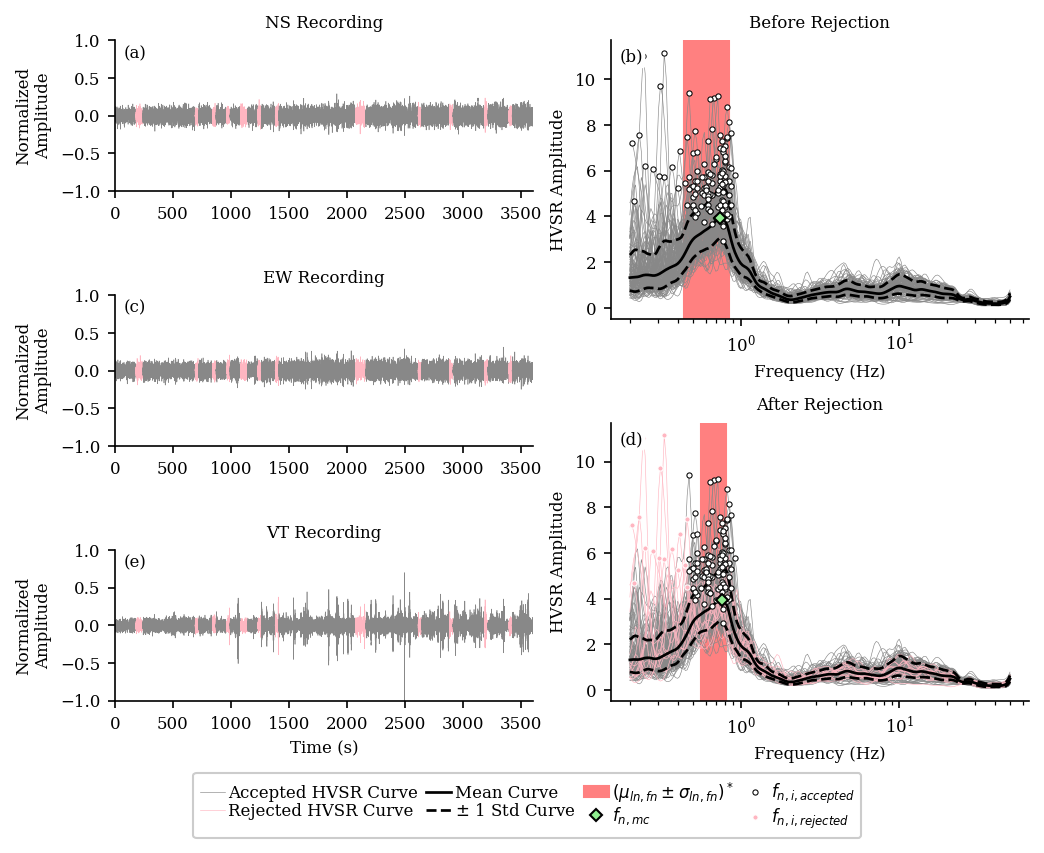

In [7]:
fig, axs = hvsrpy.plot_pre_and_post_rejection(srecords_preprocessed, hvsr)
plt.show()

## Save HVSR Results

In [8]:
save_figure = False
save_results = False
fname_prefix = "example_mhvsr_traditional_window_rejection"

if save_figure:
    fname = f"{fname_prefix}_all_panels.png"
    fig.savefig(fname)
    plt.close()
    print(f"Figure saved successfully to {fname}!")

if save_results:
    fname = f"{fname_prefix}.csv"
    hvsrpy.object_io.write_hvsr_to_file(hvsr, fname)
    print(f"Results saved successfully to {fname}!")

## Summarize HVSR Results


Statistical Summary:
--------------------


,Exponentitated Lognormal Median (units),Lognormal Standard Deviation (log units),-1 Lognormal Standard Deviation (units),+1 Lognormal Standard Deviation (units)
"Resonant Site Frequency, fn (Hz)",0.675,0.179,0.564,0.807
"Resonant Site Period, Tn (s)",1.482,0.179,1.772,1.240
"Resonance Amplitude, An",5.496,0.226,4.384,6.890


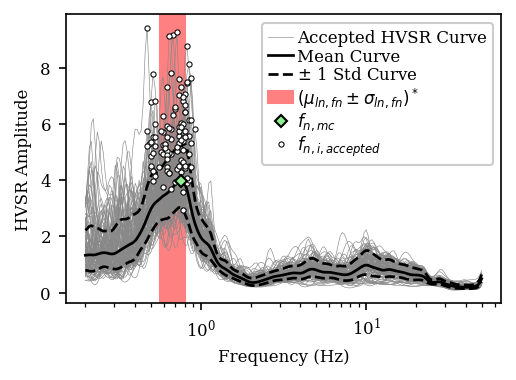

In [9]:
print("\nStatistical Summary:")
print("-"*20)
hvsrpy.summarize_hvsr_statistics(hvsr)
(fig, ax) = hvsrpy.plot_single_panel_hvsr_curves(hvsr)
plt.show()

## Save HVSR Results

In [10]:
if save_figure:
    fname = f"{fname_prefix}_single_panel.png"
    fig.savefig(fname)
    plt.close()
    print(f"Figure saved successfully to {fname}!")